In [202]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":22,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "tab:olive"]

In [171]:
# Formulate constants
n = 2
N = 50
# k = npr.uniform(1,4,n)
# p = k + npr.uniform(2,5,n)
k = np.array([2.,3.])
p = np.array([3,4.5])
k_tch = torch.tensor(k, requires_grad = True)
p_tch = torch.tensor(p, requires_grad = True)

# Formulate loss function
def loss(t,x, data,l = 5): 
    return t + l*torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True))), t, torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True)))

def gen_demand(n, N):
    F = np.random.normal(size = (n,2))
    sig = 0.1*F@(F.T)
    mu = np.random.uniform(-0.2,3,n)
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train

# Generate data
data = gen_demand(n,N)

In [172]:
# Formulate uncertainty set
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()

objective = cp.Minimize(t)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [x_r >= 0]

prob = lropt.RobustProblem(objective, constraints)

s = 13
# # Train only epsilon
result = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", initeps = 1, seed = s)
df_eps = result.df
# # Train A and b
# df1, newprob, A_fin, b_fin = prob.train(lr = 0.01, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initeps=1)

# # Grid search epsilon
# dfgrid, newprob = prob.grid(epslst = np.linspace(0.8, 2, 40), seed = s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(data.T)))
init_b = -init@np.mean(data, axis=0)
# Train A and b
result1 = prob.train(lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initA = init, initb = init_b, fixb = False)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result2 = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initA = A_fin, initb = b_fin)
df_r1 = result2.df


result3 = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initA = init, initb = init_b )
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 3, 40), initA = init, initb = init_b, seed = s)
dfgrid = result4.df

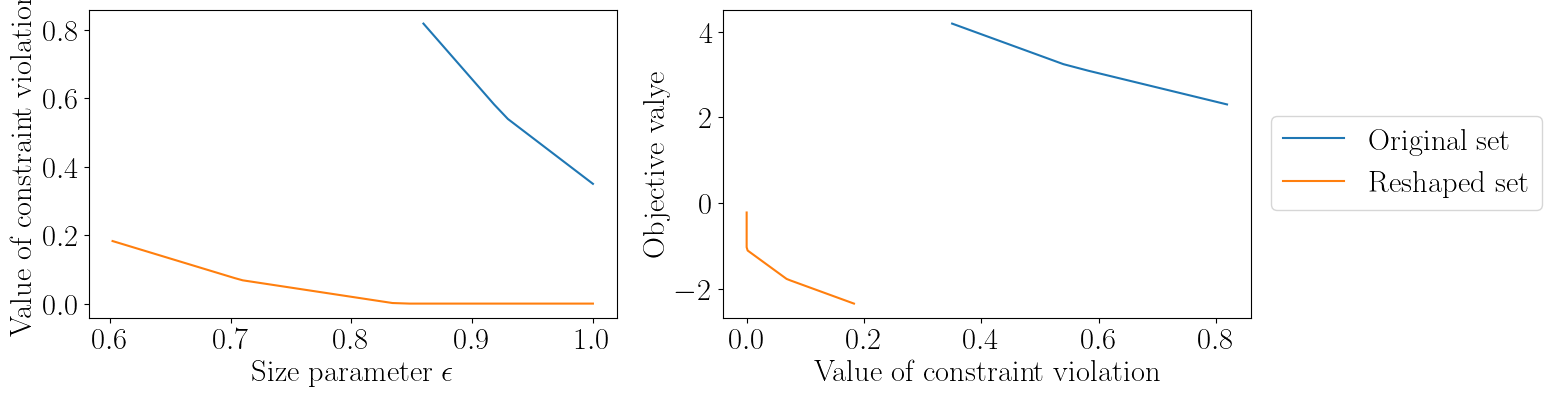

In [211]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot((df_r2['A_norm']), df_r2['Violations'], color="tab:blue", label=r"Original set")
ax1.plot((df_r1['A_norm']), df_r1['Violations'], color="tab:orange", label="Reshaped set")
# ax1.set_yscale("log")
ax1.set_xlabel("Size parameter $\epsilon$")
ax1.set_ylabel("Value of constraint violation")

ax2.plot(df_r2['Violations'][:], df_r2['Opt_val'][:], color="tab:blue", label=r"Original set")
ax2.plot(df_r1['Violations'],df_r1['Opt_val'], color="tab:orange", label="Reshaped set")
ax2.set_ylabel("Objective valye")
# ax2.set_xlim([-1,20])
ax2.set_xlabel("Value of constraint violation")
lgd = ax2.legend(loc = "lower right", bbox_to_anchor=(1.58, 0.3))
plt.savefig("ex1_curves.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


In [174]:
b_fin, init_b, A_fin, init

(array([-1.06338779, -2.94087425]),
 array([-0.84079108, -2.59617915]),
 array([[ 0.89892439, -0.16318395],
        [ 0.23377872,  0.97834749]]),
 array([[ 0.3885566 , -0.21081743],
        [-0.21081743,  0.99277369]]))

In [175]:
n = 2
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    A = init, b = init_b))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()

objective = cp.Minimize(t)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [x_r >= 0]

prob = lropt.RobustProblem(objective, constraints)
prob.solve()
# result3.reform_problem.solve()
x_opt_base = x_r.value
t_base = t.value

n = 2
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    A = A_fin, b = b_fin))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()

objective = cp.Minimize(t)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [x_r >= 0]

prob = lropt.RobustProblem(objective, constraints)
prob.solve()
# result3.reform_problem.solve()
x_opt_learned = x_r.value
t_learned = t.value

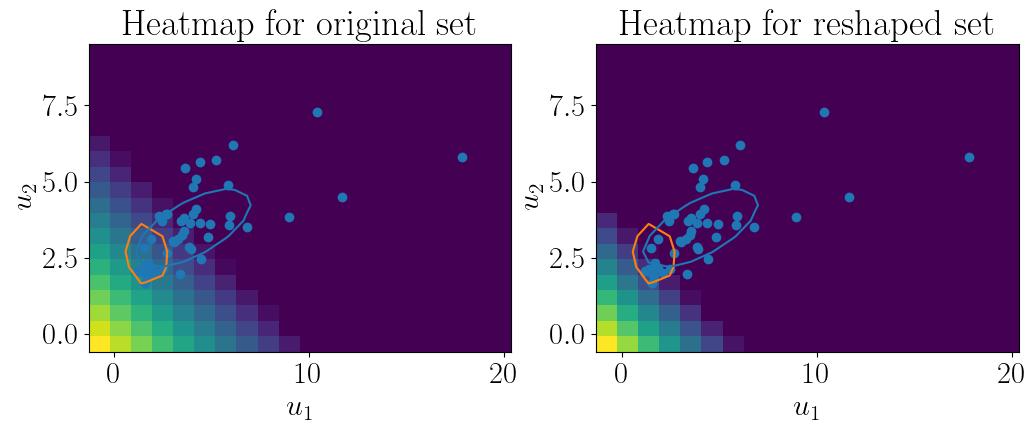

In [215]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
n = 20
offset = 2
x_min, x_max = np.min(data[:,0]) - offset, np.max(data[:,0]) + offset
y_min, y_max = np.min(data[:,1]) - offset, np.max(data[:,1]) + offset
X = np.linspace(x_min,x_max,n)
Y = np.linspace(y_min,y_max,n)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
fin_set = np.zeros((n,n))
init_set = np.zeros((n,n))
g_level_learned = np.zeros((n,n))
g_level_base = np.zeros((n,n))

# Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
for i in range(n):
    for j in range(n):
        u_vec = [x[i,j], y[i,j]]
        fin_set[i,j] = np.linalg.norm(A_fin@ u_vec  + b_fin)
        init_set[i,j] = np.linalg.norm(init@ u_vec + init_b)
        g_level_learned[i,j] = np.maximum(k @ x_opt_learned - p @ x_opt_learned, k @ x_opt_learned - p @ u_vec) - t_learned
        g_level_base[i,j] = np.maximum(k @ x_opt_base - p @ x_opt_base, k @ x_opt_base - p @ u_vec) - t_base



ax1.set_title("Heatmap for original set")
# Set x axis label for the contour plot
ax1.set_xlabel(r"$u_1$")
# Set y axis label for the contour plot
ax1.set_ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
ax1.contour(x,y,fin_set, [1], colors = ["tab:orange"])
ax1.contour(x,y,init_set, [1], colors = ["tab:blue"])
ax1.pcolormesh(x,y,g_level_base, alpha = 1)
# ax1.contour(x,y,g_level_learned, [0], colors = ["tab:orange"])
# ax1.contour(x,y,g_level_base, [0], colors = ["tab:blue"])
ax1.scatter(data[:,0],data[:,1])

ax2.set_title("Heatmap for reshaped set")
# Set x axis label for the contour plot
ax2.set_xlabel(r"$u_1$")
# Set y axis label for the contour plot
ax2.set_ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
ax2.contour(x,y,fin_set, [1], colors = ["tab:orange"])
ax2.contour(x,y,init_set, [1], colors = ["tab:blue"])
ax2.pcolormesh(x, y, g_level_learned, alpha = 1)
# ax2.contour(x,y,g_level_learned, [0], colors = ["tab:orange"])
# ax2.contour(x,y,g_level_base, [0], colors = ["tab:blue"])
ax2.scatter(data[:,0],data[:,1])

plt.savefig("Reshaped2.pdf", bbox_inches='tight')
plt.show()



In [190]:
g_level_learned[2,2]

4.131192258097328

In [203]:
plt.figure(figsize=(8, 5))
n = 25
offset = 2
x_min, x_max = np.min(data[:,0]) - offset, np.max(data[:,0]) + offset
y_min, y_max = np.min(data[:,1]) - offset, np.max(data[:,1]) + offset
X = np.linspace(x_min,x_max,n)
Y = np.linspace(y_min,y_max,n)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
fin_set = np.zeros((n,n))
init_set = np.zeros((n,n))
g_level_learned = np.zeros((n,n))
g_level_base = np.zeros((n,n))

# Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
for i in range(n):
    for j in range(n):
        u_vec = [x[i,j], y[i,j]]
        fin_set[i,j] = np.linalg.norm(A_fin@ u_vec  + b_fin)
        init_set[i,j] = np.linalg.norm(init@ u_vec + init_b)
        g_level_learned[i,j] = np.maximum(k @ x_opt_learned - p @ x_opt_learned, k @ x_opt_learned - p @ u_vec) - t_learned
        g_level_base[i,j] = np.maximum(k @ x_opt_base - p @ x_opt_base, k @ x_opt_base - p @ u_vec) - t_base



plt.title("Original and reshaped sets")
# Set x axis label for the contour plot
plt.xlabel(r"$u_1$")
# Set y axis label for the contour plot
import seaborn as sns
plt.ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
plt.contour(x,y,fin_set, [1], colors = ["tab:orange"])
plt.contour(x,y,init_set, [1], colors = ["tab:blue"])
# plt.pcolormesh(g_level_learned, alpha = 0.5)
# plt.pcolormesh(g_level_base, alpha = 0.5)
plt.contour(x,y,g_level_learned, [0], colors = ["tab:orange"])
plt.contour(x,y,g_level_base, [0], colors = ["tab:blue"])
plt.scatter(data[:,0],data[:,1])
plt.savefig("Reshaped1.pdf", bbox_inches='tight')
plt.show()


In [225]:
data1 = gen_demand(n,N)
data2 = gen_demand(n,N)
data = data1.copy()
data[0] = data2[0]

In [287]:
xvals_r = np.zeros((N,2))
loss_vals = np.zeros((N,2))
xvals_e = np.zeros((N,2))

for i in range(N):
  data = data1.copy()
  data[i] = data2[i].copy()
  n = 2
  N = 50
  # k = npr.uniform(1,4,n)
  # p = k + npr.uniform(2,5,n)
  k = np.array([2.,3.])
  p = np.array([3,4.5])
  k_tch = torch.tensor(k, requires_grad = True)
  p_tch = torch.tensor(p, requires_grad = True)
  # Formulate uncertainty set
  u = lropt.UncertainParameter(n,
                          uncertainty_set=lropt.Ellipsoidal(p=2,
                                                      data=data, loss = loss))
  # Formulate the Robust Problem
  x_r = cp.Variable(n)
  t = cp.Variable()

  objective = cp.Minimize(t)

  constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
  constraints += [x_r >= 0]

  prob = lropt.RobustProblem(objective, constraints)

  s = 13
  # # Train only epsilon
  # result = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", initeps = 1, seed = s)
  # df_eps = result.df
  # # Train A and b
  # df1, newprob, A_fin, b_fin = prob.train(lr = 0.01, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initeps=1)

  # # Grid search epsilon
  # dfgrid, newprob = prob.grid(epslst = np.linspace(0.8, 2, 40), seed = s)
  init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(data.T)))
  init_b = -init@np.mean(data, axis=0)
  # Train A and b
  result1 = prob.train(lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initA = init, initb = init_b, fixb = False)
  df1 = result1.df
  A_fin = result1.A
  b_fin = result1.b

  result2 = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initA = A_fin, initb = b_fin)
  df_r1 = result2.df
  xvals_r[i] = result2.var_values[1].detach().numpy().copy()
  loss_vals[i,0] = np.array(df_r1["Eval_val"])[-1]

  result3 = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initA = init, initb = init_b )
  df_r2 = result3.df
  xvals_e[i] = result3.var_values[1].detach().numpy().copy()
  loss_vals[i,1] = np.array(df_r2["Eval_val"])[-1]

  # # Grid search epsilon
  # result4 = prob.grid(epslst = np.linspace(0.01, 3, 40), initA = init, initb = init_b, seed = s)
  # dfgrid = result4.df

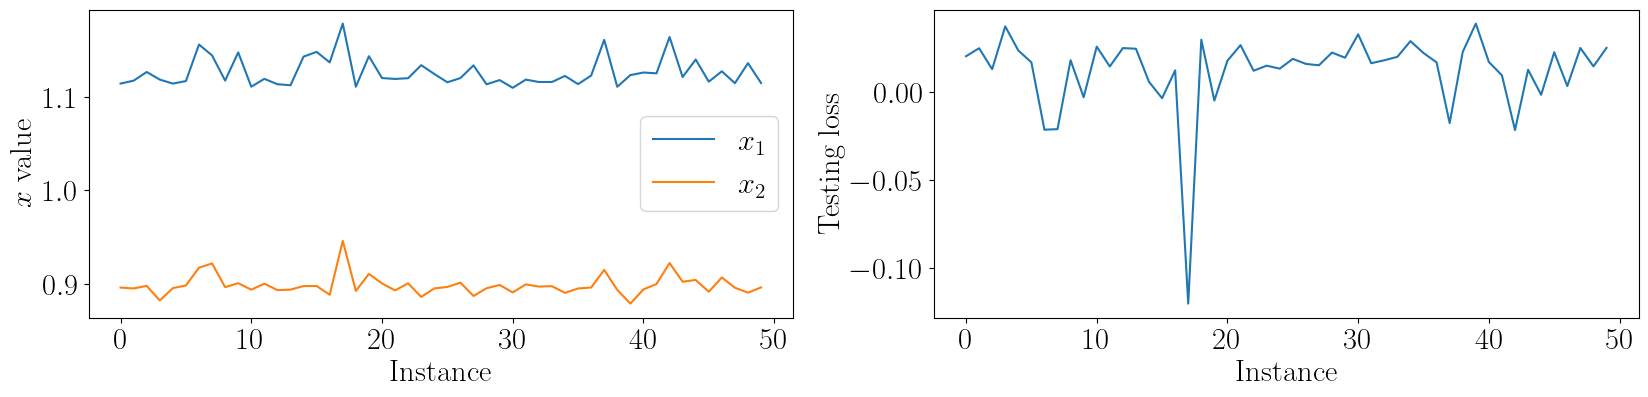

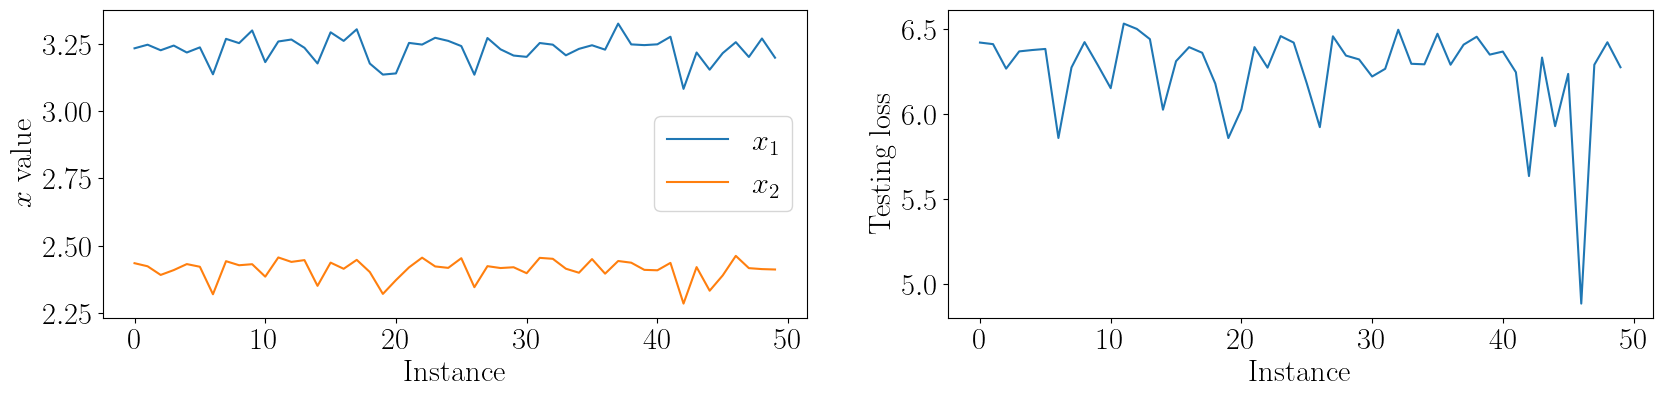

In [288]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
ax1.plot(range(N), xvals_r[:,0], label = r"$x_1$")
ax1.plot(range(N), xvals_r[:,1], label = r"$x_2$")
ax1.set_xlabel("Instance")
ax1.set_ylabel("$x$ value")
ax1.legend()

ax2.plot(range(N), loss_vals[:,0], label = "Loss")
ax2.set_xlabel("Instance")
ax2.set_ylabel("Testing loss")
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
ax1.plot(range(N), xvals_e[:,0], label = r"$x_1$")
ax1.plot(range(N), xvals_e[:,1], label = r"$x_2$")
ax1.set_xlabel("Instance")
ax1.set_ylabel("$x$ value")
ax1.legend()

ax2.plot(range(N), loss_vals[:,1], label = "Loss")
ax2.set_xlabel("Instance")
ax2.set_ylabel("Testing loss")
plt.show()

In [283]:
data = data1.copy()
xvals_r = np.zeros((N,2))
loss_vals = np.zeros((N,2))
xvals_e = np.zeros((N,2))

for i in range(N):
  data[i] = data2[i].copy()
  n = 2
  N = 50
  # k = npr.uniform(1,4,n)
  # p = k + npr.uniform(2,5,n)
  k = np.array([2.,3.])
  p = np.array([3,4.5])
  k_tch = torch.tensor(k, requires_grad = True)
  p_tch = torch.tensor(p, requires_grad = True)
  # Formulate uncertainty set
  u = lropt.UncertainParameter(n,
                          uncertainty_set=lropt.Ellipsoidal(p=2,
                                                      data=data, loss = loss))
  # Formulate the Robust Problem
  x_r = cp.Variable(n)
  t = cp.Variable()

  objective = cp.Minimize(t)

  constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
  constraints += [x_r >= 0]

  prob = lropt.RobustProblem(objective, constraints)

  s = 13
  # # Train only epsilon
  # result = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", initeps = 1, seed = s)
  # df_eps = result.df
  # # Train A and b
  # df1, newprob, A_fin, b_fin = prob.train(lr = 0.01, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initeps=1)

  # # Grid search epsilon
  # dfgrid, newprob = prob.grid(epslst = np.linspace(0.8, 2, 40), seed = s)
  init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(data.T)))
  init_b = -init@np.mean(data, axis=0)
  # Train A and b
  result1 = prob.train(lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initA = init, initb = init_b, fixb = False)
  df1 = result1.df
  A_fin = result1.A
  b_fin = result1.b

  result2 = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initA = A_fin, initb = b_fin)
  df_r1 = result2.df
  xvals_r[i] = result2.var_values[1].detach().numpy().copy()
  loss_vals[i,0] = np.array(df_r1["Eval_val"])[-1]

  result3 = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initA = init, initb = init_b )
  df_r2 = result3.df
  xvals_e[i] = result3.var_values[1].detach().numpy().copy()
  loss_vals[i,1] = np.array(df_r2["Eval_val"])[-1]

  # # Grid search epsilon
  # result4 = prob.grid(epslst = np.linspace(0.01, 3, 40), initA = init, initb = init_b, seed = s)
  # dfgrid = result4.df

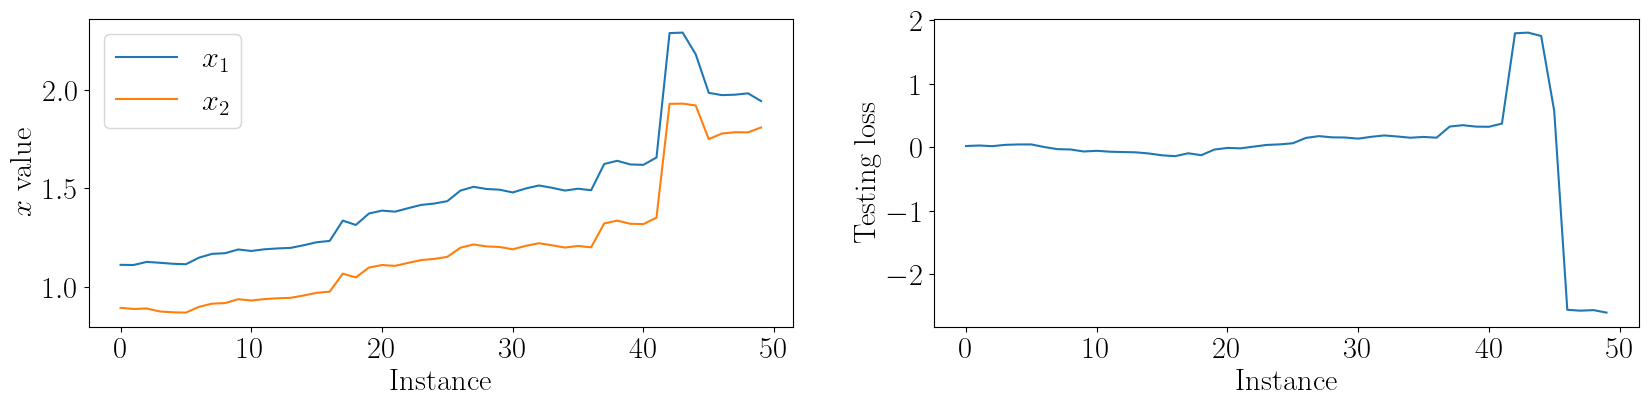

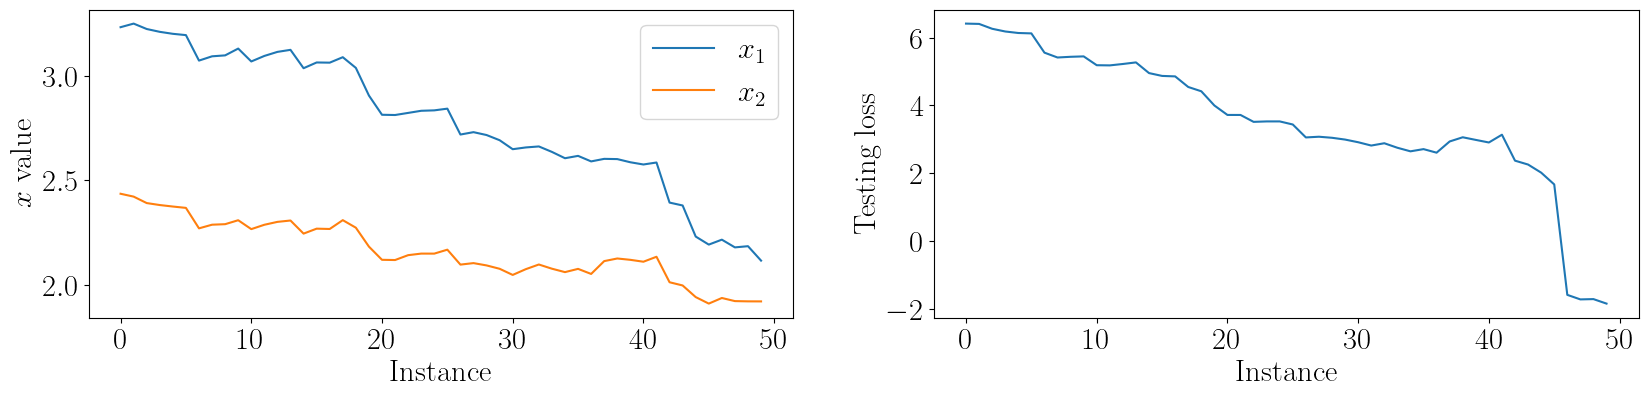

In [286]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
ax1.plot(range(N), xvals_r[:,0], label = r"$x_1$")
ax1.plot(range(N), xvals_r[:,1], label = r"$x_2$")
ax1.set_xlabel("Instance")
ax1.set_ylabel("$x$ value")
ax1.legend()

ax2.plot(range(N), loss_vals[:,0], label = "Loss")
ax2.set_xlabel("Instance")
ax2.set_ylabel("Testing loss")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
ax1.plot(range(N), xvals_e[:,0], label = r"$x_1$")
ax1.plot(range(N), xvals_e[:,1], label = r"$x_2$")
ax1.set_xlabel("Instance")
ax1.set_ylabel("$x$ value")
ax1.legend()

ax2.plot(range(N), loss_vals[:,1], label = "Loss")
ax2.set_xlabel("Instance")
ax2.set_ylabel("Testing loss")
plt.show()